# Regression and forecasting with sktime-dl
[Github](https://github.com/sktime/sktime-dl)

In this notebook, we use sktime-dl to perform regression and forecasting on univariate time series data by deep learning.

See [sktime](https://github.com/alan-turing-institute/sktime/blob/master/examples/forecasting.ipynb) for the same forecasting performed using time series algorithms.

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sktime.datasets import load_shampoo_sales, load_italy_power_demand
from sktime.highlevel.tasks import ForecastingTask
from sktime.highlevel.strategies import Forecasting2TSRReductionStrategy
from sktime.pipeline import Pipeline
from sktime.transformers.compose import Tabulariser

from sktime_dl.deeplearning import CNNRegressor, MLPRegressor

sns.set_style('whitegrid') 

/home/lucy/anaconda3/envs/sktime_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/lucy/anaconda3/envs/sktime_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/lucy/anaconda3/envs/sktime_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessin

# Regression
First, we create a dataset of regression values against time series data samples.

In [2]:
X_train, y_train = load_italy_power_demand(split='TRAIN', return_X_y=True)
X_test, y_test = load_italy_power_demand(split='TEST', return_X_y=True)

# Create some regression values
y_train = np.zeros(len(y_train))
for i in range(len(X_train)):
    y_train[i] = X_train.iloc[i].iloc[0].iloc[1]
    y_train[i] = y_train[i] + X_train.iloc[i].iloc[0].iloc[10]
y_test = np.zeros(len(y_test))
for i in range(len(X_test)):
    y_test[i] = X_test.iloc[i].iloc[0].iloc[1]
    y_test[i] = y_test[i] + X_test.iloc[i].iloc[0].iloc[10]

## Plot the dataset's regression values

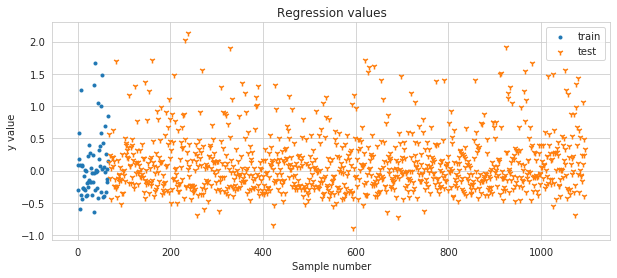

In [3]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
ax_train = np.arange(len(y_train))
ax_test = np.arange(len(y_train), len(y_train)+len(y_test))
plt.scatter(ax_train, y_train, marker='.',label="train")
plt.scatter(ax_test, y_test, marker='1', label="test")
plt.title('Regression values')
ax.set(ylabel='y value')
ax.set_xlabel('Sample number')
plt.legend();

## Train and test a deep learning model
Here, we choose use the CNN (convolutional neural network) model. Other regressors provided by sktime-dl include MLP, ResNet and InceptionTime.

In [4]:
estimator = CNNRegressor(nb_epochs=400, kernel_size=7, verbose=False)
estimator.fit(X_train, y_train)
y_predict = estimator.predict(X_test)
estimator.score(X_test, y_test)

0.8290971560461713

## Plot the result

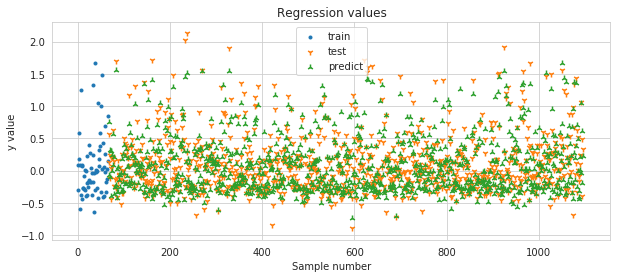

In [5]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
ax_train = np.arange(len(y_train))
ax_test = np.arange(len(y_train), len(y_train)+len(y_test))
plt.scatter(ax_train, y_train, marker='.',label="train")
plt.scatter(ax_test, y_test, marker='1', label="test")
plt.scatter(ax_test, y_predict, marker='2', label="predict")
plt.title('Regression values')
ax.set(ylabel='y value')
ax.set_xlabel('Sample number')
plt.legend();

# Forecasting
## Load a dataset
Load shampoo sales dataset from sktime containing monthly sale counts of shampoo over three years.

In [6]:
shampoo = load_shampoo_sales(return_y_as_dataframe=True)
shampoo_series = shampoo.iloc[0, 0]
shampoo_series.head()

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
Name: Sales, dtype: float64

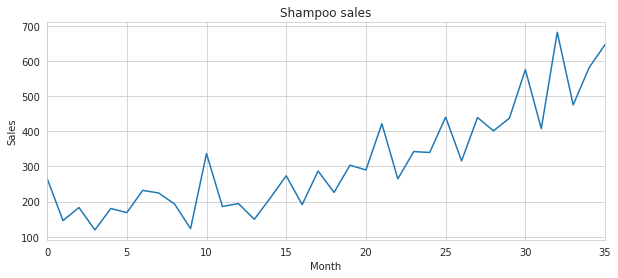

In [7]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
shampoo_series.plot(ax=ax)
plt.title('Shampoo sales')
ax.set(ylabel=shampoo_series.name)
ax.set_xlabel('Month');

## Split the data into training and test data
We will train a neural network to forecast shampoo sales over the next 6 months, using the first 30 months of data.

In [8]:
train = pd.DataFrame(pd.Series([shampoo.iloc[0, 0].iloc[:30]]), columns=shampoo.columns)
test = pd.DataFrame(pd.Series([shampoo.iloc[0, 0].iloc[30:]]), 
columns=shampoo.columns)

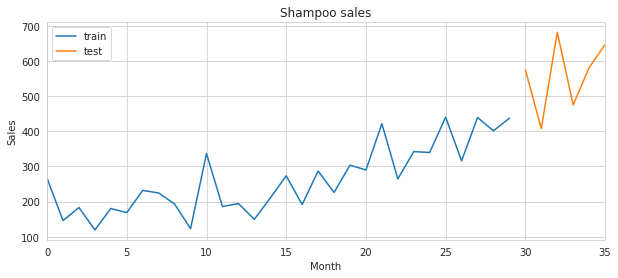

In [9]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
train.iloc[0, 0].plot(ax=ax, label='train')
test.iloc[0, 0].plot(ax=ax, label='test')
plt.title('Shampoo sales')
ax.set(ylabel=shampoo_series.name)
ax.set_xlabel('Month')
plt.legend();

## Train and test a deep learning model

A reduction strategy allows us to solve forecasting tasks using a deep learning time-series regressor and a rolling window approach.

In [10]:
window_length=10
fh = [1, 2, 3, 4, 5, 6] # forecasting horizon

regressor = MLPRegressor(nb_epochs=500, verbose=False)

steps = [
    ('tabularise', Tabulariser()),
    ('rgs', regressor)
]

with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=FutureWarning) 
    estimator = Pipeline(steps)
    task = ForecastingTask(target='ShampooSales', fh=fh, metadata=train)
    strategy = Forecasting2TSRReductionStrategy(estimator=estimator, window_length=window_length)
    strategy.fit(task, train)
predict = strategy.predict()

In [11]:
# Evaluate the forecast (root mean squared error)
np.sqrt(mean_squared_error(test.iloc[0,0], predict))

109.31394491126032

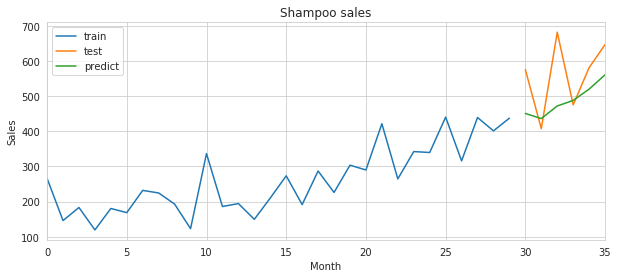

In [12]:
fig, ax = plt.subplots(1, figsize=plt.figaspect(.4))
train.iloc[0, 0].plot(ax=ax, label='train')
test.iloc[0, 0].plot(ax=ax, label='test')
predict.plot(ax=ax, label='predict')
plt.title('Shampoo sales')
ax.set(ylabel=shampoo_series.name)
ax.set_xlabel('Month')
plt.legend();